# Exploration of the Data From the Challenge

## Reading and Creation of the Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Data paths
notes_file_path = 'data/mimic-iv_notes_training_set.csv'
annotations_file_path = 'data/train_annotations.csv'

In [4]:
with open('data/SHA256SUMS.txt', 'r') as file:
    lines = file.readlines()
    last_two_hashes = [line.split()[0] for line in lines[-2:]]

hash_notes = last_two_hashes[0]
hash_annotations = last_two_hashes[1]

Check if the data is correct by computing the SHA256 hash of the files:

In [6]:
import hashlib

def compute_sha256(file_path):
    # Initialize the SHA-256 hash object
    sha256_hash = hashlib.sha256()

    # Open the file in binary mode and read in chunks
    with open(file_path, 'rb') as file:
        for byte_block in iter(lambda: file.read(4096), b""):
            sha256_hash.update(byte_block)

    # Return the hexadecimal digest of the hash
    return sha256_hash.hexdigest()

In [7]:
# Check for the hashes
assert compute_sha256(notes_file_path) == hash_notes, 'NOTES FILE DIFFERENT FROM THE ORIGINAL'
assert compute_sha256(annotations_file_path) == hash_annotations, 'ANNOTATIONS FILE DIFFERENT FROM THE ORIGINAL'

Read the data (notes and annotations):

In [8]:
notes = pd.read_csv(notes_file_path)
annotations = pd.read_csv(annotations_file_path)

In [16]:
print(f'There are {len(notes)} notes and {len(annotations)} annotations.')

There are 204 notes and 51574 annotations.


In [9]:
notes.head()

,note_id,text
0,10060142-DS-9,\nName: ___ Unit No: ___\...
1,10097089-DS-8,\nName: ___ Unit No: ___\...
2,10124346-DS-4,\nName: ___ Unit No: ___\n \n...
3,10302979-DS-5,\nName: ___ Unit No: ___\n...
4,10352433-DS-20,\nName: ___ Unit No: ___\...


In [10]:
annotations.head()

,note_id,start,end,concept_id
0,10060142-DS-9,179,190,91936005
1,10060142-DS-9,228,248,95563007
2,10060142-DS-9,294,322,45595009
3,10060142-DS-9,390,411,95563007
4,10060142-DS-9,425,444,1835003


In [12]:
# Example of a text (discharge summary)
print(notes['text'][0])

 
Name:  ___                  Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   M
 
Service: SURGERY
 
Allergies: 
Penicillins
 
Attending: ___.
 
Chief Complaint:
Biliary pancreatitis
 
Major Surgical or Invasive Procedure:
___: Laparoscopic cholecystectomy

 
History of Present Illness:
Mr. ___ is a ___ man who had severe biliary 
pancreatitis resulting in pancreatic necrosis for which he was 
treated with nasojejunal feedings and pancreatic rest.  He had 
initially had multisystem organ failure, which improved. Mr. 
___ has a large postnecrotic pseudocyst, which has been 
drained through a minimally invasive approach into his GI tract. 
 He has some debris, but this is not currently infected. The 
patient was followed by Dr. ___ in his ___ 
clinic to discuss cholecystectomy. After discussion of all 
risks, benefits and possible outcomes, patient was scheduled for 
elective cholecystectomy on ___.
 
Past Medical History:

Merge notes and annotations by note id:

In [14]:
data = notes.merge(annotations, on='note_id')

In [15]:
data.head()

,note_id,text,start,end,concept_id
0,10060142-DS-9,\nName: ___ Unit No: ___\...,179,190,91936005
1,10060142-DS-9,\nName: ___ Unit No: ___\...,228,248,95563007
2,10060142-DS-9,\nName: ___ Unit No: ___\...,294,322,45595009
3,10060142-DS-9,\nName: ___ Unit No: ___\...,390,411,95563007
4,10060142-DS-9,\nName: ___ Unit No: ___\...,425,444,1835003


Extract the terms that correspond to each [start, end] for each annotation:

In [17]:
def get_term(df, row):
    start = df['start'].iloc[row]
    end = df['end'].iloc[row]
    text = df['text'].iloc[row]
    concept_id = df['concept_id'].iloc[row]
    return text[start:end]

In [25]:
# Example:

idx = 300
get_term(data, idx)

'aortic valve stenosis'

In [26]:
# Add a column of the text term recognised
data['term'] = data.apply(lambda row: get_term(data, row.name), axis=1)

In [27]:
data.head()

,note_id,text,start,end,concept_id,term
0,10060142-DS-9,\nName: ___ Unit No: ___\...,179,190,91936005,Penicillins
1,10060142-DS-9,\nName: ___ Unit No: ___\...,228,248,95563007,Biliary pancreatitis
2,10060142-DS-9,\nName: ___ Unit No: ___\...,294,322,45595009,Laparoscopic cholecystectomy
3,10060142-DS-9,\nName: ___ Unit No: ___\...,390,411,95563007,biliary \npancreatitis
4,10060142-DS-9,\nName: ___ Unit No: ___\...,425,444,1835003,pancreatic necrosis


## Data Exploration

### Analysis of the Term Frequency 

In [28]:
def plot_terms_freqs(terms_dict):
    plt.bar([i for i in range(len(terms_dict))], terms_dict.values())

In [29]:
term_ids = data['concept_id']
unique_term_ids = term_ids.unique()

In [31]:
print(f'There are {len(term_ids)} concepts, and {len(unique_term_ids)} different conepts.')

There are 51574 concepts, and 5336 different conepts.


Most common concepts:

In [32]:
term_counts = data['concept_id'].value_counts()
term_counts.head(20)

concept_id
281900007    584
66842004     489
5880005      455
767002       416
38341003     394
28317006     384
14089001     383
441689006    368
70901006     365
386661006    359
29857009     348
37254006     347
33747003     329
267036007    327
104589004    314
118227000    313
268925001    312
25469001     309
248234008    303
54706004     293
Name: count, dtype: int64

In [33]:
term_counts_dict = dict(term_counts)

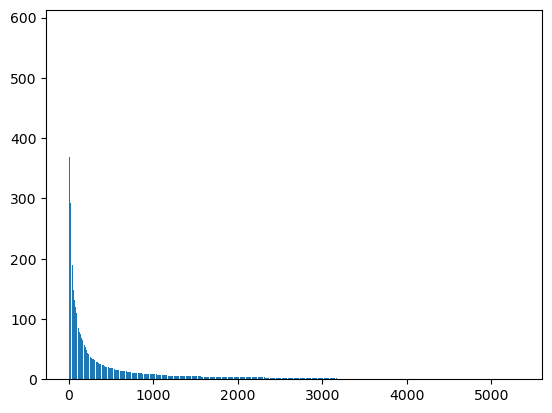

In [34]:
# Bar plot of each concept id frequency
plot_terms_freqs(term_counts_dict)

In [35]:
def filter_dict(original_dict, threshold):
    filtered_dict = {}
    for key, value in original_dict.items():
        if value > threshold:
            filtered_dict[key] = value
        else:
            break
    return filtered_dict

In [36]:
relevant_terms_dict = filter_dict(term_counts_dict, 10)

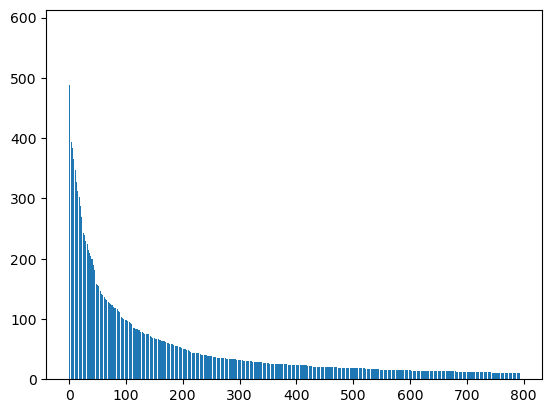

In [37]:
# Bar plot of the concept id frequencies greater than 10
plot_terms_freqs(relevant_terms_dict)

Plot the histogram of the number of appearances per concept (linear and logarithmic):

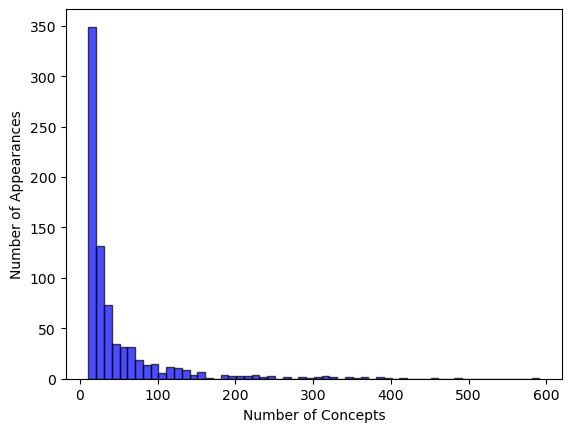

In [38]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_terms_freqs(terms_dict, bin_width=1):
    # Get the frequency of each frequency
    freqs = list(terms_dict.values())
    freq_of_freqs = Counter(freqs)
    
    # Create bins for the histogram
    min_freq = min(freq_of_freqs.keys())
    max_freq = max(freq_of_freqs.keys())
    bins = np.arange(min_freq, max_freq + bin_width, bin_width)
    
    # Prepare data for histogram
    counts, _ = np.histogram(freqs, bins=bins)
    
    # Plot the histogram
    plt.hist(freqs, bins=bins, weights=np.ones_like(freqs), edgecolor='black', alpha=0.7, color='blue')
    
    # Add title and labels
    #plt.title("Histogram of Term Frequencies")
    plt.xlabel("Number of Concepts")
    plt.ylabel("Number of Appearances")
    
    # Show the plot
    plt.show()

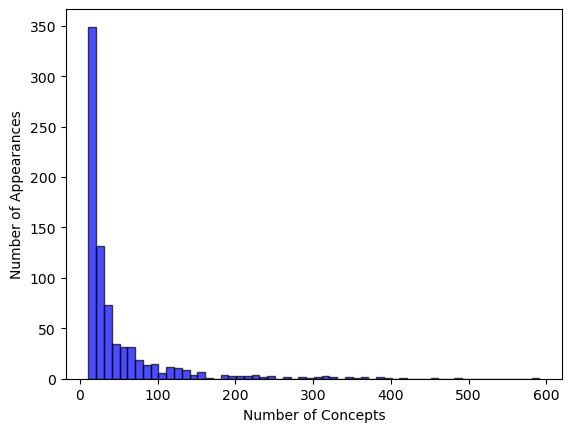

In [40]:
plot_terms_freqs(relevant_terms_dict, bin_width=10)

In [41]:
def plot_log_terms_freqs(terms_dict, bin_width=1):
    # Get the frequency of each frequency
    freqs = list(terms_dict.values())
    
    # Create bins for the histogram
    min_freq = min(freqs)
    max_freq = max(freqs)
    bins = np.arange(min_freq, max_freq + bin_width, bin_width)
    
    # Plot the histogram
    plt.hist(freqs, bins=bins, edgecolor='black', alpha=0.7, color='blue')
    
    # Set y-axis to logarithmic scale
    plt.yscale('log')
    
    # Add title and labels
    #plt.title("Histogram of Term Frequencies (Log Scale)")
    plt.xlabel("Number of Concepts")
    plt.ylabel("Number of Appearances (Log Scale)")
    
    # Show the plot
    plt.show()

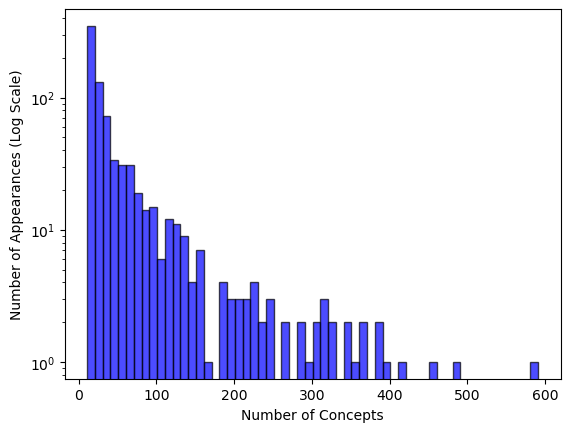

In [42]:
plot_log_terms_freqs(relevant_terms_dict, bin_width=10)

### Three Most Common Concepts

#### First place

In [44]:
print(f"Concept id: {list(term_counts_dict.keys())[0]}\nMeaning: 'No abnormality detected (finding)'")

Concept id: 281900007
Meaning: 'No abnormality detected (finding)'


In [55]:
first = list(data.loc[data['concept_id'] == list(term_counts_dict.keys())[0]]['term'].unique())
print(f'Appears in {len(first)} different ways:\n')
print(first)

Appears in 55 different ways:

['NAD', 'no acute', 'No c/c/e', 'No acute', 'negative', 'intact', 'clear', 'normal', 'No acute intrathoracic process', 'no drop', 'abnormality', 'good', 'Clear', 'unremarkable', 'no evidence', 'no significant abnormalities', 'WNL', 'no gross abnormality', 'No evidence', 'Normal', 'abnormalities', 'NEG', 'No disease', 'No significant disease', 'no c/c/e', 'neg', 'NGTD', 'No \nevidence', 'NORMAL', 'no significant', 'No acute abnormality', 'No \nacute abnormality', 'nad', 'no\nacute', 'No \nacute', 'no \nfocal \nabnormality', 'No C/C/E', 'No c/c/e ', 'did not have any \nabnormalities', 'no\nevidence', 'no \nevidence', 'wnl', 'undetecable', 'undetectable', 'Negative', 'are \nclear', 'No significant abnormalities', 'No \nsignificant abnormalities', 'NEGATIVE', 'grossly non-focal', 'without R/R/W', 'negataive', 'are clear', 'No deficits', 'benign']


#### Second place

In [53]:
print(f"Concept id: {list(term_counts_dict.keys())[1]}\nMeaning: 'Red cell distribution width determination (procedure)'")

Concept id: 66842004
Meaning: 'Red cell distribution width determination (procedure)'


In [56]:
second = list(data.loc[data['concept_id'] == list(term_counts_dict.keys())[1]]['term'].unique())
print(f'Appears in {len(second)} different ways:\n')
print(second)

Appears in 2 different ways:

['RDW', 'RDWSD']


#### Third place

In [51]:
print(f"Concept id: {list(term_counts_dict.keys())[2]}\nMeaning: 'Physical examination procedure (procedure)'")

Concept id: 5880005
Meaning: 'Physical examination procedure (procedure)'


In [57]:
third = list(data.loc[data['concept_id'] == list(term_counts_dict.keys())[2]]['term'].unique())
print(f'Appears in {len(third)} different ways:\n')
print(third)

Appears in 19 different ways:

['exam', 'HEENT', 'NECK', 'PHYSICAL EXAM', 'Neck', 'Physical Exam', 'Exam', 'PHYSICAL EXAMINATION', 'physical \nexam', 'HENT', 'physical examination', 'GU', 'Head/eyes', 'ENT/neck', 'exams', 'HEAD', 'Heent', 'BACK', 'PE']


### Numerical Terms

Check if there are any relevant numerical terms:

In [60]:
nums = [str(i) for i in range(10)]

numerical_terms = {} # i:(freq of numerical in that term)

for i in range(len(term_counts_dict)):
    terms_list = list(data.loc[data['concept_id'] == list(term_counts_dict.keys())[i]]['term'])
    for j, t in enumerate(terms_list):
        for n in nums:
            if n in t:
                if i not in numerical_terms:
                    numerical_terms[i] = 1
                else:
                    numerical_terms[i] += 1
                break
    if i in numerical_terms:
        numerical_terms[i] /= len(terms_list)

In [61]:
get_terms = lambda i: list(data.loc[data['concept_id'] == list(term_counts_dict.keys())[i]]['term'])

In [63]:
len(numerical_terms.keys())

154

In [67]:
for idx in numerical_terms.keys():
    print('-------------------------------------------------\n\n')
    print('---> ID =', idx, 'contains numbers in some apparitions:\n')
    print(get_terms(idx))

-------------------------------------------------


---> ID = 24 contains numbers in some apparitions:

['HCO3', 'bicarb', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3', 'HCO3

### Vital Signs

In [73]:
i = 15 # Vital signs apparition
vs_id = list(term_counts_dict.keys())[i]
print(f'Vital Signs has the SNOMED CT ID of {vs_id}.')

Vital Signs has the SNOMED CT ID of 118227000.


Filter by the ID of Vital Signs:

In [75]:
filt = data.loc[data.concept_id == vs_id]
filt.head()

,note_id,text,start,end,concept_id,term
25,10060142-DS-9,\nName: ___ Unit No: ___\...,1258,1260,118227000,VS
144,10097089-DS-8,\nName: ___ Unit No: ___\...,2225,2227,118227000,VS
382,10124346-DS-4,\nName: ___ Unit No: ___\n \n...,1384,1395,118227000,vital signs
405,10124346-DS-4,\nName: ___ Unit No: ___\n \n...,1842,1853,118227000,Vital signs
463,10124346-DS-4,\nName: ___ Unit No: ___\n \n...,3254,3256,118227000,VS


In [78]:
print(f'Vital Signs appears {len(filt)} times.')

Vital Signs appears 313 times.


Example of surrounding text arround Vital Signs:

In [80]:
j = 0

start = filt.iloc[j].start
end = filt.iloc[j].end
print(notes.loc[notes.note_id == filt.iloc[j].note_id].text.iloc[0][start-25:end+50])

l Exam:
Prior Discharge:
VS: 98.3, 83, 137/69, 16, 98% RA
GEN: NAD, AAO x 3
C


#### Creation of the Vital Signs data

In [81]:
vs_list = []
notes_list = []

for j in range(len(filt)):
    start = filt.iloc[j].start
    end = filt.iloc[j].end
    text = notes.loc[notes.note_id == filt.iloc[j].note_id].text.iloc[0]#[start-25:end+40]
    vs_list.append(text[end:end+100])
    notes_list.append(filt.iloc[j].text)

In [83]:
vs_list_oneline = [s.replace("\n", " ") for s in vs_list]

In [84]:
df = pd.DataFrame({
    'text': vs_list_oneline,
    'note': notes_list
})

In [88]:
import csv

df.to_csv('vital_signs.csv', index=False, header=False)